# Beyond GLMs
Exploring other Machine Learning algorithms for spike prediction

### Table of contents
0. Data
0. GLM
    0. with _pyglmnet_
    0. with keras/theano
0. Cross validation
0. Model comparison
0. Neural Networks
0. Gradient Boosting (_xgboost_)
0. Ensemble methods
    0. Level 2: Stacked Generalization
0. Population analysis: Gradient Boosting vs GLM
0. ADD: 
    0. _Level 3: weighted model averaging:_
    0. GAMs (Generalized additive models)_

## Abstract 
The interpretability of the interpretable

Linear non-linear poisson models or Generalized Linear Models with poisson output are the prefered machine learning method in Computational Neuroscience for building encoding models of spiking activity. They have the advantage of being interpretable, convex and easy to use. Several other machine learning methods like neural networks, random forests and gradient boosting and machine learning technique such as bagging and stacking have been more successful in machine learning competions where the emphasis is on predictive power. 

Interpretability is important (except maybe in BMI) however, the interpretability of a model should be put into the context of how much predictive power the model has relative to what is possible: if an interpretable model has half of the predictive power of a non-interpretable one with the same features can we really interpret the interpretable? 

Here we compared the predictive power of GLMs with poisson output with that of Neural Networks and Gradient Boosting. We used a center out reaching task and recording from 193 M1 neurons. We find that Gradient Boosting greatly outperforms GLMs with no need for feature engineering.

Sugestion: Use gradient boosting to know how far you can get with the features you have, that will put the interpretable model's predictive value and thus it's interpretability into perspective. After that try feature engineering to get the interpretable model to that predictive level.

In [184]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

#for plots
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6)
    ax.yaxis.set_tick_params(size=6)

colors=['#F5A21E', '#134B64', '#EF3E34', '#02A68E', '#FF07CD']

import tqdm as tqdm

## Dependencies
- pyglmnet
- xgboost
- theano
- keras

To do: complete dependencies

## References

1. _To Explain or to Predict?_
Galit Shmueli. Statistical Science, 2010
[[Abstract](http://www.jstor.org/stable/41058949?seq=1#page_scan_tab_contents), [pdf](https://arxiv.org/pdf/1101.0891.pdf)]
2. _Choosing prediction over explanation in psychology: Lessons from machine learning_.
Tal Yarkoni Jacob Westfall. Figshare. 2016 [[Abstract](https://figshare.com/articles/Choosing_prediction_over_explanation_in_psychology_Lessons_from_machine_learning/2441878)]

To do: add references



# 1. Data
We used a center-out reaching dataset. Data was already preprocessed: binned and normalized so not clear what the units are... that's why axes don't have units, sorry for that... We have hand position, hand velocity and spikes (193 PMd (or M1?) neurons, from Lee Miller's lab, possibly collected by Brian Dekleva).

**To do:** get original data set and do the preprocessing here, possibly using the [spykes](https://github.com/KordingLab/spykes) package. Use _spykes.neurovis_ to visualize rasters and psths and _spykes.neuropop_ to the tradicional models of encoding and population decoding.

#### Load data

In [185]:
import scipy.io
math = scipy.io.loadmat('../data/4Hugo_new.mat')

### 1.1 Covariates

In [186]:
data = pd.DataFrame()
data['time'] =  math['time'][0]
data['handPos_x'] =  math['handPos'][0]
data['handPos_y'] =  math['handPos'][1]
data['handVel_x'] =  math['handVel'][0]
data['handVel_y'] =  math['handVel'][1]
data.head() 

,time,handPos_x,handPos_y,handVel_x,handVel_y
0,12.591,0.002905,-0.303636,-0.011201,-0.006237
1,12.641,0.002260,-0.303869,-0.010743,-0.000833
2,12.691,0.002399,-0.303631,0.017680,0.012094
3,12.741,0.004010,-0.302399,0.044667,0.038700
4,12.791,0.006386,-0.300673,0.042202,0.017021


#### plot

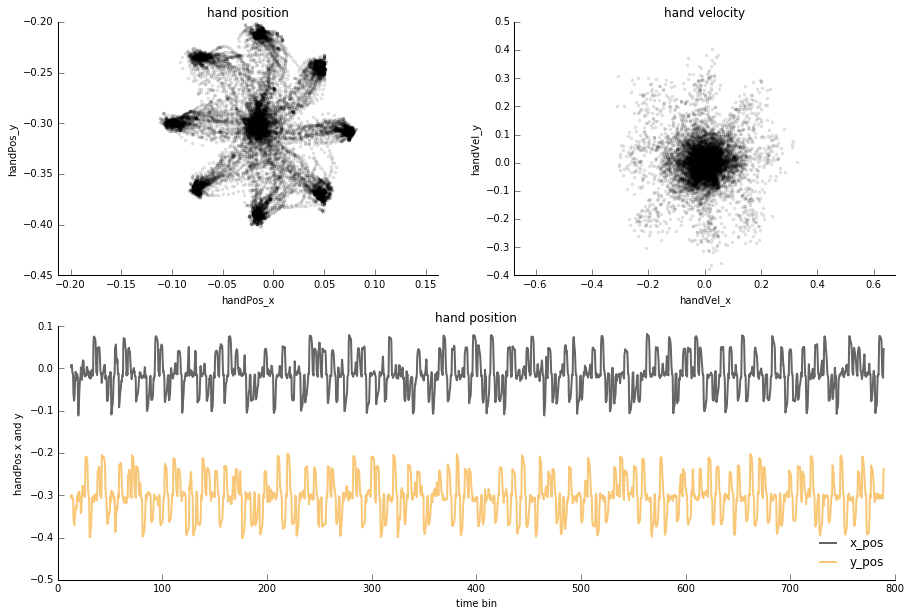

In [187]:
plt.figure(figsize=(15,10))

plt.subplot(221)
simpleaxis(plt.gca())
plt.plot(data['handPos_x'], data['handPos_y'], 'k.', alpha=0.1)

plt.xlabel('handPos_x')
plt.ylabel('handPos_y')
plt.axis('equal')
plt.title('hand position')

plt.subplot(222)
simpleaxis(plt.gca())
plt.plot(data['handVel_x'], data['handVel_y'], 'k.', alpha=0.1)

plt.xlabel('handVel_x')
plt.ylabel('handVel_y')
plt.axis('equal')
plt.title('hand velocity')

plt.subplot(212)
simpleaxis(plt.gca())
alpha = 0.6
lw = 2
plt.plot(data['time'], data['handPos_x'], 'k-', alpha=alpha, lw=lw)
plt.plot(data['time'], data['handPos_y'], '-', color=colors[0], alpha=alpha, lw=lw)

plt.xlabel('time bin')
plt.ylabel('handPos x and y')
plt.title('hand position')
plt.legend(['x_pos', 'y_pos'], frameon=False, loc=4)

plt.show()

#### compute more covariates/features

In [188]:
data['velDir'] = np.arctan2(data['handVel_y'], data['handVel_x'])
data['cos_velDir'] = np.cos(data['velDir'])
data['sin_velDir'] = np.sin(data['velDir'])
data['speed'] = np.sqrt(data['handVel_x'].values**2+data['handVel_y'].values**2)
data.head()

,time,handPos_x,handPos_y,handVel_x,handVel_y,velDir,cos_velDir,sin_velDir,speed
0,12.591,0.002905,-0.303636,-0.011201,-0.006237,-2.633523,-0.873685,-0.486491,0.012820
1,12.641,0.002260,-0.303869,-0.010743,-0.000833,-3.064245,-0.997010,-0.077271,0.010775
2,12.691,0.002399,-0.303631,0.017680,0.012094,0.599956,0.825360,0.564606,0.021420
3,12.741,0.004010,-0.302399,0.044667,0.038700,0.713933,0.755792,0.654812,0.059100
4,12.791,0.006386,-0.300673,0.042202,0.017021,0.383375,0.927408,0.374053,0.045505


### 1.2 Neural data
#### Choose neuron

In [189]:
neuron_n = 165
y = math['spikes'][neuron_n-1]

#### check for movement direction tuning and speed tuning

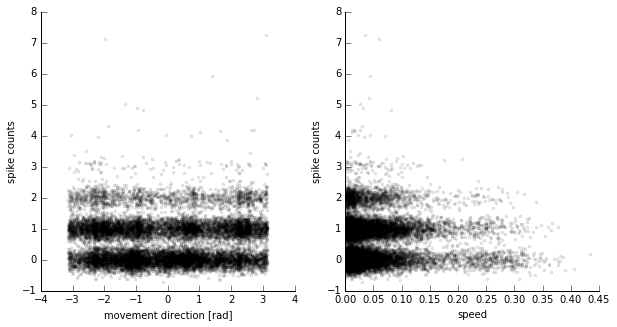

In [190]:
plt.figure(figsize=(10,5))

y_noise = np.random.randn(np.size(y))
nnoise = 0.2

plt.subplot(121)
simpleaxis(plt.gca())

plt.plot(data['velDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.xlabel('movement direction [rad]')
plt.ylabel('spike counts')

plt.subplot(122)
simpleaxis(plt.gca())

plt.plot(data['speed'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.xlabel('speed')
plt.ylabel('spike counts')

plt.show()

# 2. GLM with poisson output

### using [pyglmnet](https://github.com/pavanramkumar/pyglmnet)
this is a python implementation of R's glmnet package

In [191]:
from pyglmnet import GLM

the firing rate is not linear on the movement angle, we need to do some feature engineering. More details [here](https://github.com/KordingLab/spykes/blob/master/notebooks_documentation/gradient_descent_tutorial.ipynb).

In [192]:
angles_x  = np.linspace(-np.pi, np.pi, 360)
Xangles = list()
Xangles.append(np.cos(angles_x))
Xangles.append(np.sin(angles_x))
Xangles = np.transpose(np.array(Xangles))

In [193]:
X = data[['cos_velDir', 'sin_velDir']].values

glm = GLM(distr='poissonexp', alpha=0., reg_lambda=[0.], tol=1e-6)
glm.fit(X, y)
Yt_hat_glm_pyglmnet = glm.predict(Xangles)[0]

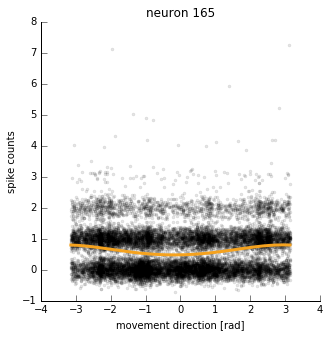

In [194]:
plt.figure(figsize=(5,5))
plt.plot(data['velDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.title('neuron %s' % neuron_n)
plt.plot(angles_x, Yt_hat_glm_pyglmnet, c=colors[0], lw=3)

simpleaxis(plt.gca())
plt.xlabel('movement direction [rad]')
plt.ylabel('spike counts')
plt.show()

### using neural networks (keras+theano)
It's a neural network with no hidden layers, we just have to add the non-linearity and specify that the loss funcion in the loglikelihood

In [195]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.core import Lambda

def glm_keras(Xr, Yr, Xt):
    
    model = Sequential()
    model.add(Dense(1, input_dim=np.shape(Xr)[1], init='uniform', activation='linear'))
    model.add(Lambda(lambda x: np.exp(x)))
    model.compile(loss='poisson', optimizer='rmsprop')

    model.fit(Xr, Yr, nb_epoch=4, verbose=0, validation_split=0.0)
    
    Yt = model.predict_proba(Xt, verbose=0)
    
    return Yt[:,0]

In [196]:
X = data[['cos_velDir', 'sin_velDir']].values

Yt_hat_glm_keras = glm_keras(X, y, Xangles)

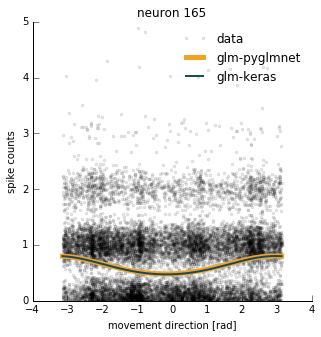

In [197]:
plt.figure(figsize=(5,5))
plt.plot(data['velDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.title('neuron %s' % neuron_n)
plt.plot(angles_x, Yt_hat_glm_pyglmnet, c=colors[0], lw=5)
plt.plot(angles_x, Yt_hat_glm_keras, colors[1], lw=2)

simpleaxis(plt.gca())
plt.xlabel('movement direction [rad]')
plt.ylabel('spike counts')
plt.ylim([0,5])
plt.legend(['data', 'glm-pyglmnet', 'glm-keras'], frameon=False)
plt.show()

# 3. Cross-validation
because...

[![crossvalidate](http://imgs.xkcd.com/comics/linear_regression.png)](http://xkcd.com/1725/)

#### first define some functions

In [198]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import LabelKFold

def glm_pyglmnet(Xr, Yr, Xt):
    glm = GLM(distr='poissonexp', alpha=0., reg_lambda=[0.], tol=1e-6)
    glm.fit(Xr, Yr)
    Yt = glm.predict(Xt)[0]
    return Yt

def poisson_pseudoR2(y, yhat, ynull):
    eps = np.spacing(1)
    L1 = np.sum(y*np.log(eps+yhat) - yhat)
    L1_v = y*np.log(eps+yhat) - yhat
    L0 = np.sum(y*np.log(eps+ynull) - ynull)
    LS = np.sum(y*np.log(eps+y) - y)
    R2 = 1-(LS-L1)/(LS-L0)
    return R2

def fit_cv(X, Y, algorithm = 'glm_pyglmnet', n_cv=10, verbose=1, label=[]):

    if np.ndim(X)==1:
        X = np.transpose(np.atleast_2d(X))

    if len(label)>0:
        skf  = LabelKFold(np.squeeze(label), n_folds=n_cv)
    else:
        skf  = KFold(n=np.size(Y), n_folds=n_cv, shuffle=True, random_state=42)

    i=1
    Y_hat=np.zeros(len(Y))
    pR2_cv = list()
    for idx_r, idx_t in skf:
        if verbose > 1:
            print '...runnning cv-fold', i, 'of', n_cv
        i+=1
        Xr = X[idx_r, :]
        Yr = Y[idx_r]
        Xt = X[idx_t, :]
        Yt = Y[idx_t]

        Yt_hat = eval(algorithm)(Xr, Yr, Xt)
        Y_hat[idx_t] = Yt_hat

        pR2 = poisson_pseudoR2(Yt, Yt_hat, np.mean(Yr))
        pR2_cv.append(pR2)

        if verbose > 1:
            print 'pR2: ', pR2

    if verbose > 0:
        print("pR2_cv: %0.6f (+/- %0.6f)" % (np.mean(pR2_cv),
                                             np.std(pR2_cv)/np.sqrt(n_cv)))

    return Y_hat, pR2_cv

def plot_model_comparison(models_for_plot, models=[], color='r', title=None):

    plt.plot([-1, len(models_for_plot)], [0,0],'--k', alpha=0.4)

    mean_pR2 = list()
    sem_pR2 = list()

    for model in models_for_plot:
        PR2_art = models[model]['PR2']
        mean_pR2.append(np.mean(PR2_art))
        sem_pR2.append(np.std(PR2_art)/np.sqrt(np.size(PR2_art)))

    plt.bar(np.arange(np.size(mean_pR2)), mean_pR2, 0.8, align='center',
            ecolor='k', alpha=0.6, color=color, ec='w', yerr=np.array(sem_pR2),
            tick_label=models_for_plot)
    plt.plot(np.arange(np.size(mean_pR2)), mean_pR2, 'k.', markersize=15)

    plt.ylabel('pseudo-R2')
    simpleaxis(plt.gca())
    if title:
        plt.title(title)

In [199]:
Models = dict()

In [200]:
X = data[['cos_velDir','sin_velDir']].values

Yt_hat, PR2 = fit_cv(X, y, algorithm = 'glm_pyglmnet', n_cv=10, verbose=2, label=[])

Models['glm_pyglmnet'] = dict()
Models['glm_pyglmnet']['Yt_hat'] = Yt_hat
Models['glm_pyglmnet']['PR2'] = PR2

...runnning cv-fold 1 of 10
pR2:  0.010019890029
...runnning cv-fold 2 of 10
pR2:  0.0168116663433
...runnning cv-fold 3 of 10
pR2:  0.0349843219529
...runnning cv-fold 4 of 10
pR2:  0.0146880780126
...runnning cv-fold 5 of 10
pR2:  0.0237365021152
...runnning cv-fold 6 of 10
pR2:  0.0196638484732
...runnning cv-fold 7 of 10
pR2:  0.0365429316253
...runnning cv-fold 8 of 10
pR2:  0.0323160555976
...runnning cv-fold 9 of 10
pR2:  0.022617668313
...runnning cv-fold 10 of 10
pR2:  0.0104399660205
pR2_cv: 0.022182 (+/- 0.002920)


In [201]:
X = data[['cos_velDir','sin_velDir']].values

Yt_hat, PR2 = fit_cv(X, y, algorithm = 'glm_keras', n_cv=10, verbose=2, label=[])

Models['glm_keras'] = dict()
Models['glm_keras']['Yt_hat'] = Yt_hat
Models['glm_keras']['PR2'] = PR2

...runnning cv-fold 1 of 10
pR2:  0.00983237699909
...runnning cv-fold 2 of 10
pR2:  0.016634302004
...runnning cv-fold 3 of 10
pR2:  0.0352116296299
...runnning cv-fold 4 of 10
pR2:  0.0145444489717
...runnning cv-fold 5 of 10
pR2:  0.0238028940136
...runnning cv-fold 6 of 10
pR2:  0.0196532615869
...runnning cv-fold 7 of 10
pR2:  0.0365872347826
...runnning cv-fold 8 of 10
pR2:  0.0325616740312
...runnning cv-fold 9 of 10
pR2:  0.0225691669558
...runnning cv-fold 10 of 10
pR2:  0.0098425363047
pR2_cv: 0.022124 (+/- 0.002980)


# 4. Model comparison

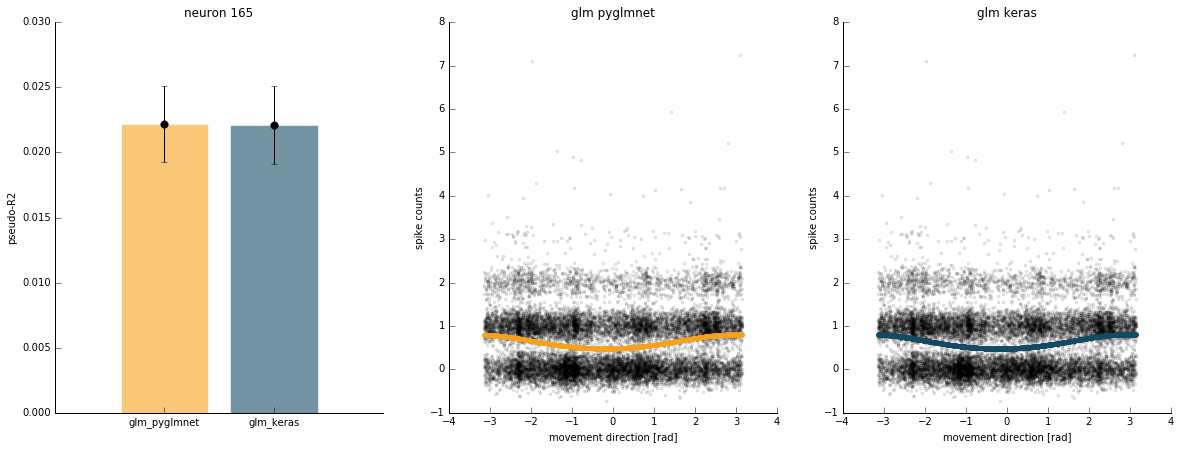

In [202]:
plt.figure(figsize=(20,7))

plt.subplot(131)
plot_model_comparison(['glm_pyglmnet', 'glm_keras'], color=[colors[0],colors[1]], models=Models)
plt.title('neuron %s' % neuron_n)

plt.subplot(132)
simpleaxis(plt.gca())
plt.plot(data['velDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.plot(data['velDir'], Models['glm_pyglmnet']['Yt_hat'], '.', c=colors[0], lw=5)

plt.xlabel('movement direction [rad]')
plt.ylabel('spike counts')
plt.title('glm pyglmnet')

plt.subplot(133)
plt.plot(data['velDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.plot(data['velDir'], Models['glm_keras']['Yt_hat'], '.', c=colors[1], lw=3)

simpleaxis(plt.gca())
plt.xlabel('movement direction [rad]')
plt.ylabel('spike counts')
plt.title('glm keras')
plt.show()

# 5. Neural network
In the GLM we had to do some feature engineering: we used _cos()_ and _sin()_ of the movement angle. This is because the firing rate is not a linear function of movement direction. We hope NN to learn that linearization. 

Let's first see what we get if we try a GLM on the movement direction only: 

In [203]:
X = data['velDir'].values

Yt_hat, PR2 = fit_cv(X, y, algorithm = 'glm_pyglmnet', n_cv=10, verbose=1, label=[])

Models['glm_pyglmnet_angle'] = dict()
Models['glm_pyglmnet_angle']['Yt_hat'] = Yt_hat
Models['glm_pyglmnet_angle']['PR2'] = PR2

pR2_cv: 0.000269 (+/- 0.000243)


Now let's add some hidden layers and some dropout to the NN to avoid overfitting and see if it can learn the features:

In [204]:
def nn_poisson(Xr,Yr, Xt):

    if np.ndim(Xr)==1:
        Xr = np.transpose(np.atleast_2d(Xr))
    
    model = Sequential()
    model.add(Dense(3000, input_dim=np.shape(Xr)[1], init='uniform', activation='tanh'))
    model.add(Dropout(0.6))
    model.add(Dense(100, init='uniform', activation='tanh'))
    model.add(Dropout(0.6))

    model.add(Dense(1, activation='linear'))
   
    model.add(Lambda(lambda x: np.exp(x)))
    
    model.compile(loss='poisson', optimizer='adam')

    hist = model.fit(Xr, Yr, nb_epoch=4, verbose=0, validation_split=0.0)
    
    result = model.predict_proba(Xt)
    return result[:,0]

**Note**: this will probably be slow if you don't have GPUs

In [205]:
# this won't be that fast
X = data['velDir'].values

Yt_hat, PR2 = fit_cv(X, y, algorithm = 'nn_poisson', n_cv=10, verbose=2, label=[])

Models['nn_angle'] = dict()
Models['nn_angle']['Yt_hat'] = Yt_hat
Models['nn_angle']['PR2'] = PR2

...runnning cv-fold 1 of 10
1344/1554 [========================>.....] - ETA: 0spR2:  0.00736634674493
...runnning cv-fold 2 of 10
1376/1554 [=========================>....] - ETA: 0spR2:  0.0146824815319
...runnning cv-fold 3 of 10
1376/1554 [=========================>....] - ETA: 0spR2:  0.0130588483929
...runnning cv-fold 4 of 10
1376/1554 [=========================>....] - ETA: 0spR2:  0.0127085394865
...runnning cv-fold 5 of 10
1376/1554 [=========================>....] - ETA: 0spR2:  0.0141932198472
...runnning cv-fold 6 of 10
1344/1554 [========================>.....] - ETA: 0spR2:  0.0118592031025
...runnning cv-fold 7 of 10
1376/1553 [=========================>....] - ETA: 0spR2:  0.0264270636366
...runnning cv-fold 8 of 10
1344/1553 [========================>.....] - ETA: 0spR2:  0.0214956278414
...runnning cv-fold 9 of 10
1344/1553 [========================>.....] - ETA: 0spR2:  0.0171012663782
...runnning cv-fold 10 of 10
 896/1553 [================>.............] - ETA: 0s

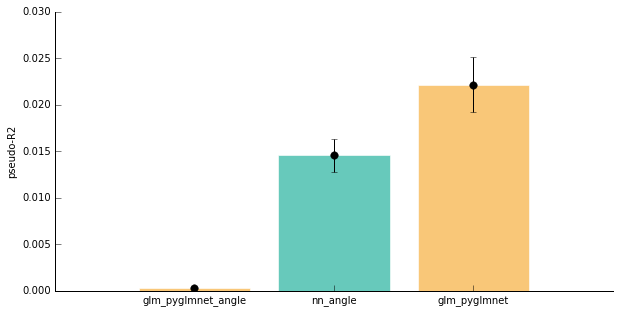

In [206]:
plt.figure(figsize=(10,5))
plot_model_comparison(['glm_pyglmnet_angle', 'nn_angle', 'glm_pyglmnet'], \
                      color=[colors[0], colors[3], colors[0]], models=Models)

**Exercise**: Improve the NN architecture and training to reach GLM's performance.
**Exercise**: Does it work with other/all neurons?

# 6. Gradient Boosting
eXtreme Gradient Boosting with [XGBoost](http://xgboost.readthedocs.io/en/latest/tutorials/index.html)

In [207]:
import xgboost as xgb
def xgb_poisson(Xr, Yr, Xt):
    param = {'objective': "count:poisson", #for poisson output
    'eval_metric': "logloss", #loglikelihood loss
    'max_depth': 1, #this is the only parameter we have set, it's one of the way or regularizing
    'seed': 2925, #for reproducibility
    'silent': 1}
    param['nthread'] = -1 #with -1 it will use all available threads

    dtrain = xgb.DMatrix(Xr, label=Yr)
    dtest = xgb.DMatrix(Xt)

    num_round = 200
    bst = xgb.train(param, dtrain, num_round)

    Yt = bst.predict(dtest)
    return Yt

In [208]:
X = data['velDir'].values

Yt_hat, PR2 = fit_cv(X, y, algorithm = 'xgb_poisson', n_cv=10, verbose=2, label=[])

Models['xgb_angle'] = dict()
Models['xgb_angle']['Yt_hat'] = Yt_hat
Models['xgb_angle']['PR2'] = PR2

...runnning cv-fold 1 of 10
pR2:  0.0115324137036
...runnning cv-fold 2 of 10
pR2:  0.0198052037698
...runnning cv-fold 3 of 10
pR2:  0.0355574911181
...runnning cv-fold 4 of 10
pR2:  0.0132103970966
...runnning cv-fold 5 of 10
pR2:  0.0250105800081
...runnning cv-fold 6 of 10
pR2:  0.0212413898478
...runnning cv-fold 7 of 10
pR2:  0.0392984144262
...runnning cv-fold 8 of 10
pR2:  0.0346476295031
...runnning cv-fold 9 of 10
pR2:  0.0258091080442
...runnning cv-fold 10 of 10
pR2:  0.0162010655578
pR2_cv: 0.024231 (+/- 0.002903)


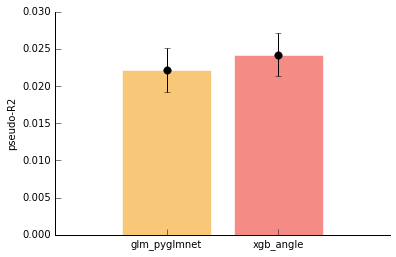

In [209]:
plot_model_comparison(['glm_pyglmnet', 'xgb_angle'], 
                       color=[colors[0], colors[2]], models=Models)

XGBoost (maybe almost) outperforms GLM without the need for feature engeneering

### Model comparison: using all the original features

In [210]:
X = data[['handVel_x', 'handVel_x', 'handPos_x', 'handPos_y']].values

#### <font color='#F5A21E'>glm</font>

In [211]:
Yt_hat, PR2 = fit_cv(X, y, algorithm = 'glm_pyglmnet', n_cv=10, verbose=1, label=[])

Models['glm_ori'] = dict()
Models['glm_ori']['Yt_hat'] = Yt_hat
Models['glm_ori']['PR2'] = PR2

pR2_cv: 0.057657 (+/- 0.001297)


#### <font color='#02A68E'>nn</font>

In [212]:
Yt_hat, PR2 = fit_cv(X, y, algorithm = 'nn_poisson', n_cv=10, verbose=1, label=[])

Models['nn_ori'] = dict()
Models['nn_ori']['Yt_hat'] = Yt_hat
Models['nn_ori']['PR2'] = PR2

1344/1553 [========================>.....] - ETA: 0spR2_cv: 0.141259 (+/- 0.004908)


#### <font color='#EF3E34'>xgb</font>

In [213]:
Yt_hat, PR2 = fit_cv(X, y, algorithm = 'xgb_poisson', n_cv=10, verbose=1, label=[])

Models['xgb_ori'] = dict()
Models['xgb_ori']['Yt_hat'] = Yt_hat
Models['xgb_ori']['PR2'] = PR2

pR2_cv: 0.195729 (+/- 0.004698)


#### plot

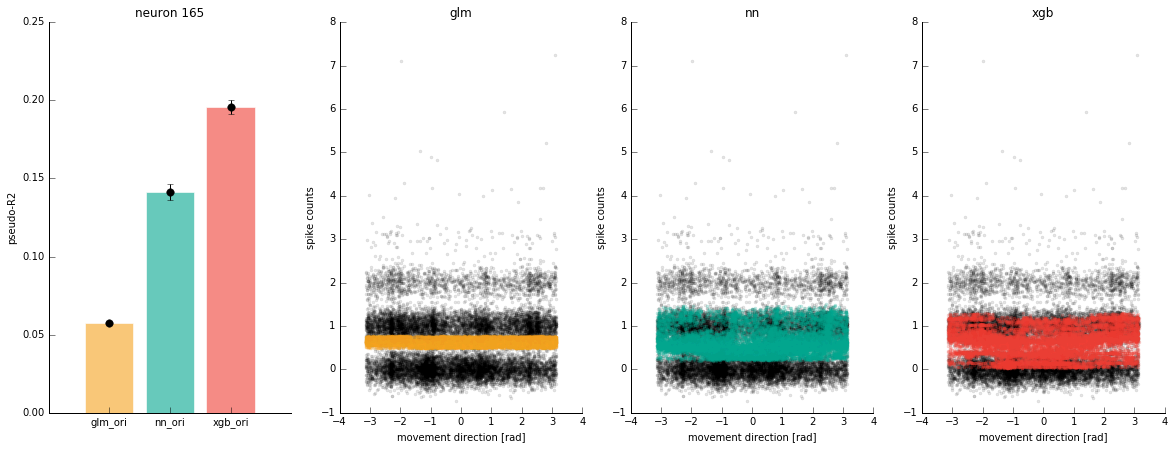

In [214]:
plt.figure(figsize=(20,7))

plt.subplot(141)
plot_model_comparison(['glm_ori', 
                      'nn_ori', 'xgb_ori'], color=[colors[0], colors[3], colors[2]], models=Models)

plt.title('neuron %d' % neuron_n)

plt.subplot(142)
plt.plot(data['velDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.plot(data['velDir'], Models['glm_ori']['Yt_hat'], '.', c=colors[0], alpha=0.2)

simpleaxis(plt.gca())
plt.xlabel('movement direction [rad]')
plt.ylabel('spike counts')
plt.title('glm')

plt.subplot(143)
plt.plot(data['velDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.plot(data['velDir'], Models['nn_ori']['Yt_hat'], '.', c=colors[3], alpha=0.2)

simpleaxis(plt.gca())
plt.xlabel('movement direction [rad]')
plt.ylabel('spike counts')
plt.title('nn')

plt.subplot(144)
plt.plot(data['velDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.plot(data['velDir'], Models['xgb_ori']['Yt_hat'], '.', c=colors[2], alpha=0.2)

simpleaxis(plt.gca())
plt.xlabel('movement direction [rad]')
plt.ylabel('spike counts')
plt.title('xgb')
plt.show()

### Model comparison: original plus the extra computed features

In [215]:
X = data.drop('time', axis=1).values

#### <font color='#F5A21E'>glm</font>

In [216]:
Yt_hat, PR2 = fit_cv(X, y, algorithm = 'glm_pyglmnet', n_cv=10, verbose=1, label=[])

Models['glm_all'] = dict()
Models['glm_all']['Yt_hat'] = Yt_hat
Models['glm_all']['PR2'] = PR2

pR2_cv: 0.073203 (+/- 0.002519)


#### <font color='#02A68E'>nn</font>

In [217]:
Yt_hat, PR2 = fit_cv(X, y, algorithm = 'nn_poisson', n_cv=10, verbose=1, label=[])

Models['nn_all'] = dict()
Models['nn_all']['Yt_hat'] = Yt_hat
Models['nn_all']['PR2'] = PR2

1312/1553 [========================>.....] - ETA: 0spR2_cv: 0.138746 (+/- 0.004951)


#### <font color='#EF3E34'>xgb</font>

In [218]:
Yt_hat, PR2 = fit_cv(X, y, algorithm = 'xgb_poisson', n_cv=10, verbose=1, label=[])

Models['xgb_all'] = dict()
Models['xgb_all']['Yt_hat'] = Yt_hat
Models['xgb_all']['PR2'] = PR2

pR2_cv: 0.198798 (+/- 0.004483)


#### plot

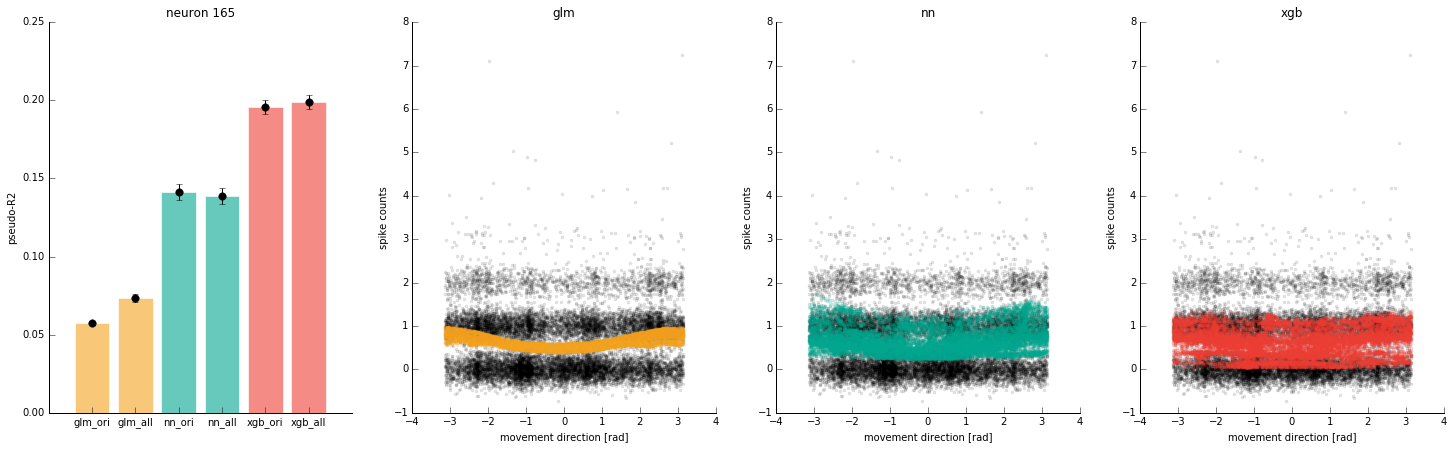

In [219]:
plt.figure(figsize=(25,7))

plt.subplot(141)
plot_model_comparison(['glm_ori', 'glm_all',
                       'nn_ori','nn_all', 'xgb_ori', 'xgb_all'], 
                       color=[colors[0], colors[0], colors[3], colors[3], colors[2], colors[2]], 
                       models=Models)

plt.title('neuron %d' % neuron_n)

plt.subplot(142)
plt.plot(data['velDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.plot(data['velDir'], Models['glm_all']['Yt_hat'], '.', c=colors[0], alpha=0.2)

simpleaxis(plt.gca())
plt.xlabel('movement direction [rad]')
plt.ylabel('spike counts')
plt.title('glm')

plt.subplot(143)
plt.plot(data['velDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.plot(data['velDir'], Models['nn_all']['Yt_hat'], '.', c=colors[3], alpha=0.2)

simpleaxis(plt.gca())
plt.xlabel('movement direction [rad]')
plt.ylabel('spike counts')
plt.title('nn')


plt.subplot(144)
plt.plot(data['velDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.plot(data['velDir'], Models['xgb_all']['Yt_hat'], '.', c=colors[2], alpha=0.2)

simpleaxis(plt.gca())
plt.xlabel('movement direction [rad]')
plt.ylabel('spike counts')
plt.title('xgb')
plt.show()

**Exercise**: try to optimize XGBoost's parameters. First by hand and after maybe using [Spearmint](https://github.com/HIPS/Spearmint) or [BayesianOptimization](https://github.com/fmfn/BayesianOptimization).

**Exercise**: Improve the NN architecture and training to reach XGB's performance.

# 7. Ensemble methods: Stacking
In this [Ensemble method](https://en.wikipedia.org/wiki/Ensemble_learning#Stacking) we use the predictions of different models as features.

**Note**: It's important to seed the folds in the cv, otherwise there will be leakage and massive overfiting

In [220]:
X = list()
X.append(Models['glm_all']['Yt_hat'])
X.append(Models['nn_all']['Yt_hat'])
X.append(Models['xgb_all']['Yt_hat'])
X = np.transpose(np.array(X))

Yt_hat, PR2 = fit_cv(X, y, algorithm = 'xgb_poisson', n_cv=10, verbose=1, label=[])
Models['xgb_sg'] = dict()
Models['xgb_sg']['Yt_hat'] = Yt_hat
Models['xgb_sg']['PR2'] = PR2

pR2_cv: 0.198242 (+/- 0.004824)


**Exercise**: try stacking it with a diferent algorithm, e.g. a nn.

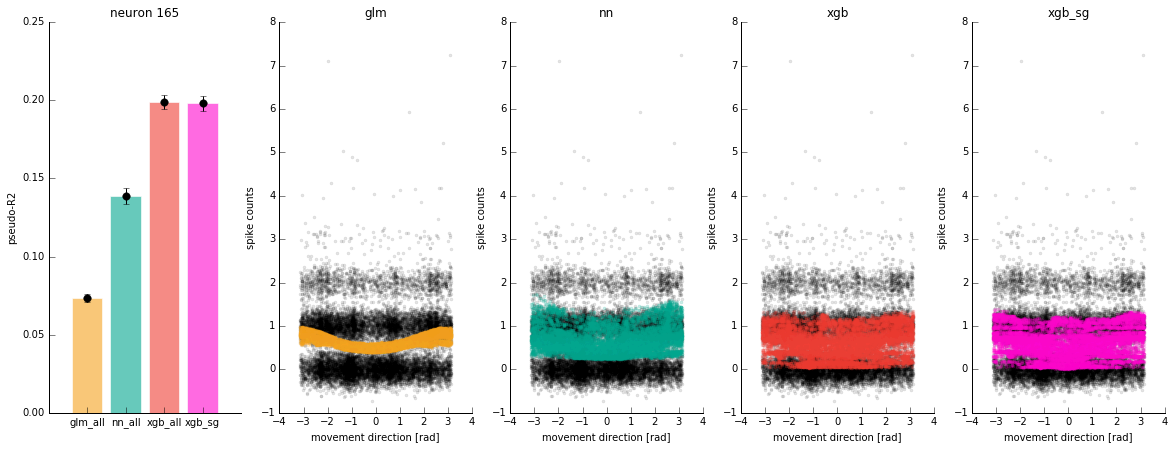

In [221]:
plt.figure(figsize=(20,7))

plt.subplot(151)
plot_model_comparison(['glm_all', 'nn_all', 'xgb_all', 'xgb_sg'], 
                       color=[colors[0], colors[3], colors[2], colors[4]],
                       models=Models)

plt.title('neuron %d' % neuron_n)

plt.subplot(152)
plt.plot(data['velDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.plot(data['velDir'], Models['glm_all']['Yt_hat'], '.', c=colors[0], alpha=0.2)

simpleaxis(plt.gca())
plt.xlabel('movement direction [rad]')
plt.ylabel('spike counts')
plt.title('glm')

plt.subplot(153)
plt.plot(data['velDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.plot(data['velDir'], Models['nn_all']['Yt_hat'], '.', c=colors[3], alpha=0.2)

simpleaxis(plt.gca())
plt.xlabel('movement direction [rad]')
plt.ylabel('spike counts')
plt.title('nn')

plt.subplot(154)
plt.plot(data['velDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.plot(data['velDir'], Models['xgb_all']['Yt_hat'], '.', c=colors[2], alpha=0.2)

simpleaxis(plt.gca())
plt.xlabel('movement direction [rad]')
plt.ylabel('spike counts')
plt.title('xgb')

plt.subplot(155)
plt.plot(data['velDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.plot(data['velDir'], Models['xgb_sg']['Yt_hat'], '.', c=colors[4], alpha=0.2)

simpleaxis(plt.gca())
plt.xlabel('movement direction [rad]')
plt.ylabel('spike counts')
plt.title('xgb_sg')
plt.show()

**Exercise**: add other models, even worse models can capture some particular aspect that excapes the best models and might be useful in the staking

**Exercise**: try do weighted model averaging of the predictions of diferent stacks. Optimize the weights on the training set.

**Exercise**: train, validation and test split: divide the original set into train and test set (say 20% for test). Leave the testset untouched, never use it for training. 1. Do cross validation in the training set (train/validation split). Check that the cross validation accurately predicts the preformance on the testset. 2. Try not using the same train/validation splits for the different models and see how that overestimates the performance predicted by cv. 3. Use bootstrap to get confidence intervals for the performance on the testset: use _scikits.bootstrap_.

# 8. Population: Gradient Boosting vs GLM

In [39]:
X = data.drop('time', axis=1).values

Models['glm_all_pop'] = dict()
Models['glm_all_pop']['PR2']  = list()
Models['glm_all_pop']['Yt_hat']  = list()
Models['xgb_all_pop'] = dict()
Models['xgb_all_pop']['PR2']  = list()
Models['xgb_all_pop']['Yt_hat']  = list()

nneurons = np.shape(math['spikes'])[0]
for i in tqdm(range(nneurons)):
    #print 'running for neuron %d' % i
    y = math['spikes'][i]

    #print 'glm...'
    Yt_hat, PR2 = fit_cv(X, y, algorithm = 'glm_pyglmnet', n_cv=10, verbose=0, label=[])
    Models['glm_all_pop']['PR2'].append(PR2)
    Models['glm_all_pop']['Yt_hat'].append(Yt_hat)

    #print 'xgb...'
    Yt_hat, PR2 = fit_cv(X, y, algorithm = 'xgb_poisson', n_cv=10, verbose=0, label=[])
    Models['xgb_all_pop']['PR2'].append(PR2)
    Models['xgb_all_pop']['Yt_hat'].append(Yt_hat)

100%|██████████| 197/197 [1:59:09<00:00, 29.83s/it]


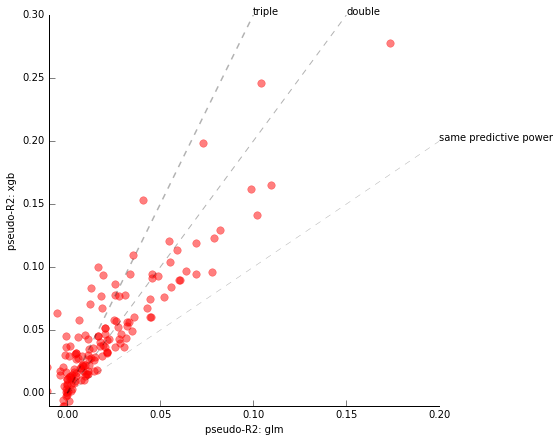

In [48]:
plt.figure(figsize=(7,7))
xx = np.mean(np.array(Models['glm_all_pop']['PR2']), axis=1)
yy = np.mean(np.array(Models['xgb_all_pop']['PR2']), axis=1)
lim = 0.30
alpha_lines = 0.3
alpha = 0.5
msize = 15

plt.plot(xx, yy,'r.', ms=msize, alpha=alpha)
plt.plot([0, lim], [0, lim], 'k--', lw=0.5, alpha=alpha_lines)
plt.plot([0, lim], [0, 2.*lim], 'k--', lw=1, alpha=alpha_lines)
plt.plot([0, lim], [0, 3.*lim], 'k--', lw=1.5, alpha=alpha_lines)

ax = plt.gca()
simpleaxis(ax)
ax.annotate('same predictive power', xy=(lim-0.1, lim-0.1), xytext=(lim-0.1, lim-0.1))
ax.annotate('double', xy=(lim/2., lim), xytext=(lim/2., lim))
ax.annotate('triple', xy=(lim/3., lim), xytext=(lim/3., lim))
plt.xlabel('pseudo-R2: glm')
plt.ylabel('pseudo-R2: xgb')
plt.ylim([-0.01, lim])
plt.xlim([-0.01, lim-0.1])
plt.show()

**Exercise**: Do some feature engineering to bring the dots closer to the "same predictive power" line

**More**: Try including past. Try CNNs, RNNs, LSTMs. Try decoding.

**Exercise**: try to add regularization to the glm and see and see if it helps. pyglmnet allows for l1, l2 and elastic-net regularization